# CS-EJ3311 - Deep Learning with Python, 09.09.2020-18.12.2020
## Round 1 -   Gradient Based Optimization and Learning
S. Abdurakhmanova and A. Jung

Aalto University (Espoo, Finland) and Fitech.io (Finland) 

This notebook demonstrates a simple but powerful method to find an optimal choice for the weight vector $\mathbf{w}$ of a predictor. The idea is to tune (adjust) the weight vector according to the gradient of the loss function. The loss function represents the average loss incurred over a training set for a particular weight vector. This average loss is also known as the **training error** of a predictor. By evaluating the training error for predictors with different weight vectors, we obtain an objective or **loss function** $f(\mathbf{w})$. The loss function maps a weight vector to the training error incurred by the predictor map corresponding to that weight vector. 

We will detail a simple iterative algorithm which is called **gradient descent** (GD). Loosely speaking, GD finds an approximate minimizer of the training error by incrementally improving the current guess for the optimal weights by moving into the opposite gradient direction. We will also discuss a slight variation of GD known as **stochastic gradient descent** (SGD). SGD is one of the most widely used optimization methods within deep learning.

## Learning Goals

- understand how to learn a predictor map by minimizing a loss function ("training error")

- understand how gradients can be used to tune (parameters of) predictor map to minimize loss function 

- understand motivation for and implementation of stochastic gradient descent SGD

- understand SGD components "batch", "batch size", "learning rate" and "epochs"

- be aware of some advanced variants of SGD such as ADAM or RMSprop

## Recommended Reading

-  Loss function [chapter 1.1.5](https://livebook.manning.com/book/deep-learning-with-python/chapter-1/49) of the book "Deep Learning with Python" by F. Chollet. 
-  Gradient-based optimization [chapter 2.4](https://livebook.manning.com/book/deep-learning-with-python/chapter-2/193) of the book "Deep Learning with Python" by F. Chollet. 

## Additional Material (Optional!)

### Hypothesis Space and Loss Functions

- Video on Hypothesis Space https://youtu.be/CDcRfak1Mh4
- Video on Loss Function https://youtu.be/Uv9lihDfsBs
- Chapter 2 and 3 of "Machine Learning: Basic Principles" https://arxiv.org/pdf/1805.05052.pdf

### Derivatives and Gradients

- https://www.mathsisfun.com/calculus/derivatives-introduction.html
- (chapters 3-4) https://openstax.org/books/calculus-volume-1/pages/3-1-defining-the-derivative#27277

### Stochastic Gradient  Descent

- Andrew Ng, https://www.youtube.com/watch?v=F6GSRDoB-Cg 
- StatQuest, https://www.youtube.com/watch?v=sDv4f4s2SB8
- 3Blue1Brown, https://www.youtube.com/watch?v=IHZwWFHWa-w
- Chapter 5 of "Machine Learning: Basic Principles" https://arxiv.org/pdf/1805.05052.pdf
- Optimization Chapter of Deep Learning Book https://www.deeplearningbook.org/contents/optimization.html

### Variants of SGD

- Adam, https://youtu.be/JXQT_vxqwIs
- RMSprop, https://youtu.be/_e-LFe_igno


## Introduction

Every machine learning (ML) method involves a (more or less explicit) choice of a **hypothesis space**. The hypothesis space of a ML method is a subset of all possible **predictor maps**. A predictor map $h(\mathbf{x})$ maps the feature vector $\mathbf{x}$ of a data point to the predicted label $\hat{y} = h(\mathbf{x})$. The main goal of many ML methods is to find a good predictor map such that $\hat{y} \approx y$ for any data point. 

For computational reasons, it is impossible to consider all possible maps. There are already uncountable infinite number of maps that use a single real-valued feature $x \in \mathbb{R}$ and output a real-valued prediction $\hat{y} \in \mathbb{R}$. Any ML method that runs on a computer with finite resources, can only use a subset of predictor maps which we refer to as the hypothesis space underlying that ML method. 

The hypothesis space is a design choice. Finding a good choice for a given dataset and computational infrastructure might be challenging and often requires some experience in applying different ML methods. Since current desktop computers are good at manipulating matrices and vectors, a very popular choice for a hypothesis space is the space 
of linear maps. Indeed, linear maps can be naturally represented by vectors and matrices. 

Let us consider data points characterized by $d$ features $x_{1},\ldots,x_{d}$ and one real-valued label $y$. Here, a **linear predictor** is of the form  

$$ h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x} = \sum_{i=1}^{d} w_{i} x_{i}$$

with some weights $w_{1},\ldots,w_{d}$ which we stack into a weight (or parameter) vector $$\mathbf{w} = \big(w_{1},\ldots,w_{d}\big)^{T}.$$ A particular choice for the weight vector results in a particular predictor map $h^{(\mathbf{w})}(\mathbf{x})$. Finding a good predictor becomes equivalent to finding a weight vector such that the corresponding predictor $h^{(\mathbf{w})}(\mathbf{x})$ performs well. 

The focus of this course on a particular class of ML methods, i.e., deep learning methods. Deep learning methods use hypothesis spaces that are much larger than the space of linear maps. Similar to linear maps, the predictor maps used by deep learning methods are parametrized by a weight (or parameter) vector. The entries $w_{i}$ of the weight vector are the individual weights associated with the connections (links) of an artificial neural network (ANN). 

We will discuss how ANN are used to represent non-linear predictor maps in much detail within the upcoming Round 2 of this course. For the sake of this round, we only need to know that an ANN is just a convenient way to represent a predictor map $h^{(\mathbf{w})}(\mathbf{x})$ that uses the features of a data point as input and whose function value is the predicted label value. 

Similar to linear maps, the predictor map $h^{(\mathbf{w})}(\mathbf{x})$ represented by an ANN depends on a weight vector $\mathbf{w}$. In contrast to linear predictors, the predictor map $h^{(\mathbf{w})}(\mathbf{x})$ obtained from an ANN is highly non-linear. However, the basic principle of learning a good predictor by adjusting the weight vector $\mathbf{w}$ is the same for linear regression (linear predictors) and deep learning (maps represented by ANN).

## Loss Function 

Deep learning methods aim at finding a good choice for the weights (and bias) of an **artificial neural network (ANN)**. To measure how "good" a particular choice for the weights is, we need to define a loss function. For a given pair of predicted label value $\hat{y}$ and true label value $y$, the loss function $L(y,\hat{y})$ provides a measure for the error, or "loss", incurred in predicting the true label $y$ by $\hat{y}$. We emphasize that the precise definition of the loss function is a design choice. In principle, the deep learning engineer is free to choose an arbitrary loss function used to guide the training of the ANN. 

Some particular choices for the loss function have proven useful in many applications. If the label values are numeric (like a temperature or a weight), then the squared error loss $L(y,\hat{y})=(y-\hat{y})^2$ is often a good choice for the loss function. If the label values are categories (like "cat" and "dog"), we might use  the "0/1" loss $L(y,\hat{y})=1$ if and only if $y=\hat{y}$ and $L(y,\hat{y})=0$ otherwise.

Deep neural networks are fed with a large number of labeled data points 

$$\big(\mathbf{x}^{(1)},y^{(1)}\big),\ldots,\big(\mathbf{x}^{(m)},y^{(m)}\big).$$

To measure the quality of a particular choice for the weights $\mathbf{w}$ of the ANN, we first compute the resulting predictions $\hat{y}^{(i)}$ obtained when feeding the feature vectors $\mathbf{x}^{(i)}$ into the ANN. 
Then we calculate the average loss (or "training error")

$$ (1/m) \big( L(y^{(1)},\hat{y}^{(1)})+L(y^{(2)},\hat{y}^{(2)})+\ldots+L(y^{(m)},\hat{y}^{(m)}) \big).$$

Note that the training error depends on the weights $\mathbf{w}$ of the ANN via the predictions $\hat{y}^{(i)}$. Indeed, the predictions $\hat{y}^{(i)}=h^{(\mathbf{w})}\big(\mathbf{x}^{(i)}\big)$ are obtained by applying the ANN with weights $\mathbf{w}$ to the input feature vector $\mathbf{x}^{(i)}$. By evaluating the training error for different choices for the weights, we obtain a **cost or loss function** $f(\mathbf{w})$ which guides the optimal choice for the weights $\mathbf{w}$. 

The choice for the weights resulting in minimum training error are obtained by solving 

$$ \min_{\mathbf{w} \in \mathbb{R}^{d}} f(\mathbf{w})$$

With a slight abuse of notation, we refer to the function $f(\mathbf{w})$ also as the loss function. For a given choice for the weight vector $\mathbf{w}$, the loss function $f(\mathbf{w})$ provides a quality measure for this choice. It should be clear from context if we mean by **loss function** the training error $f(\mathbf{w})$ (which is a function of a weight vector) or the loss $L(y,\hat{y})$ itself (which is a function of a pair of label values). 

## Mean Squared Error 

Maybe the most widely used loss function for applications involving numeric label values $y \in \mathbb{R}$ is the squared error loss 

$$L(y,\hat{y}) = (\underbrace{y- \hat{y}}_{\mbox{prediction error}})^{2}.$$

We assess the quality of a predictor $\hat{y} = h^{(\mathbf{w})}(\mathbf{x})$ by the average loss incurred over a set of labeled data points (the **training set**). For the squared error loss this average is referred to as the **mean squared error (MSE)** 

$$ f(\mathbf{w}) = (1/m) \big( \big( y^{(1)}-\hat{y}^{(1)}\big)^{2}+\big( y^{(2)}-\hat{y}^{(2)}\big)^{2}+\ldots+\big( y^{(m)}-\hat{y}^{(m)}\big)^{2} \big). $$
Note that the MSE on the right hands side depends on the weight vector $\mathbf{w}$ via the predictions $\hat{y}^{(i)}$ obtained by applying the predictor map $h^{(\mathbf{w})}\big(\mathbf{x}^{(i)}\big)$. 

The shape of the loss $f(\mathbf{w})$, viewed as a function of the weights $\mathbf{w}$, depends on two components. First, it depends on how the predictor map depends on the weights. Second, it depends on the choice of the loss function $L(y,\hat{y})$ used to measure the loss incurred by predicting the true label value $y$ with the prediction $\hat{y}$. 

The combination of linear predictor functions and squared error loss $L(y,\hat{y})=(y-\hat{y})^{2}$ is a very popular as they result in a [convex](https://en.wikipedia.org/wiki/Convex_function) and [differentiable](https://en.wikipedia.org/wiki/Differentiable_function) loss function $f(\mathbf{w})$. A convex function has the attractive property that any local minimum is always also a [global minimum](https://en.wikipedia.org/wiki/Maxima_and_minima#/media/File:Extrema_example_original.svg). If a convex function is also differentiable, it can be minimized by a simple but powerful algorithm which is known as **gradient descent**. 

<img src="MSELinPred.jpeg" alt="Drawing" style="width: 500px;"/>

Deep learning methods use predictor maps represented by ANN with tunable weights. In this case, the predictor depends non-linearly on the weights. As a result, we obtain (highly) non-convex loss landscapes. Below you can see examples of loss function landscapes of more complicated models (neural networks), which illustrates that finding a minimum of these loss functions is not a trivial task.

<img src="NNloss.png" alt="Drawing" style="width: 500px;"/>


<center><a href="https://www.cs.umd.edu/~tomg/projects/landscapes/">image source</a></center>
<center><a href="https://arxiv.org/abs/1712.09913/">original paper</a></center>

Here you can find more examples of visualizations for loss functions obtained from representing a predictor map using ANN:

[3D visualization of NN loss functions](http://www.telesens.co/loss-landscape-viz/viewer.html) \
[3D animation of NN loss functions](https://www.youtube.com/watch?time_continue=32&v=aq3oA6jSGro&feature=emb_logo)

## Gradient Descent 

We will now introduce a simple algorithm that allows to find (good approximations to) the optimal weight vector $\mathbf{w}_{\rm opt}$ for a predictor map $h^{(\mathbf{w})}(\mathbf{x})$. The optimum weight vector should result in the smallest possible loss  

\begin{align} 
f(\mathbf{w}_{\rm opt}) = \min_{\mathbf{w} \in \mathbb{R}^{d}} f(\mathbf{w}) \mbox{ with } f(\mathbf{w})& = (1/m) \sum_{i=1}^{m} (y^{(i)} - \hat{y}^{(i)} \big)^{2} \nonumber \\ 
& =(1/m) \sum_{i=1}^{m} (y^{(i)} - h^{(\mathbf{w})}\big(\mathbf{x}^{(i)}\big) \big)^{2}. \end{align}

**Gradient descent (GD)** constructs a sequence of weight vectors $\mathbf{w}^{(0)},\mathbf{w}^{(1)},\ldots$ such that the loss values $f\big(\mathbf{w}^{(0)}\big),f\big(\mathbf{w}^{(0)}\big),\ldots$ tends toward the minimum loss. GD is an iterative algorithm that gradually improves the current guess (approximation) $\mathbf{w}^{(k)}$ for the optimum weight vector.  

There are many different strategies for choosing the first (or initial) guess $\mathbf{w}^{(0)}$. One simple approach is to choose the initial weights randomly. Given the current weight vector $\mathbf{w}^{(k)}$, how does GD know in which "direction" to go to find a better weight vector $\mathbf{w}^{(k+1)}$? Mathematics, or [calcululs](https://en.wikipedia.org/wiki/Differential_calculus) to be specific, tells us that this direction is precisely the opposite of the gradient $\nabla f(\mathbf{w})$. More precisely, for small step size, the steepest descent is towards the opposite direction of the [gradient](https://en.wikipedia.org/wiki/Derivative). We can think of [GD](https://en.wikipedia.org/wiki/Gradient_descent) as imitating a hiker who takes a sequence of (small) steps downhill.

<img src="GradientHiker.jpeg" alt="Drawing" style="width: 400px;"/>

Given the downhill direction $- \nabla f\big(\mathbf{w}^{(k)}\big)$ at the current estimate $\mathbf{w}^{(k)}$, we take a step 

$$\mbox{(Gradient Step)} \quad \underbrace{\mathbf{w}^{(k+1)}}_{\mbox{new guess}} = \underbrace{\mathbf{w}^{(k)}}_{\mbox{current guess}} - \underbrace{\alpha}_{\mbox{step size}} \nabla f\big(\mathbf{w}^{(k)}\big).$$ 

Here, we used a tuning parameter $\alpha>0$ which adjusts the step size for the step downhill. We will refer to this parameter as **learning rate**. This name is due to the fact that choosing a larger value for $\alpha$ tends to speed up the progress of GD to reach the optimum weight vector. Thus, increasing the value of $\alpha$ tends to speed up the learning of a good weight vector for a predictor map $h^{(\mathbf{w})}$. 

The GD algorithm requires the specification of a suitable learning rate  $\alpha$ and initial guess $\mathbf{w}^{(0)}$ and then repeating the gradient step for a sufficient number of iterations. One possible stopping criterion is to use a fixed number of iterations which might be dictated by constraints on processing duration we grant for GD (computing time costs money, [see here](https://aws.amazon.com/emr/pricing/)). 

Another option is to monitor the loss function and stop if consecutive iterates do not result in any significant decrease. Similarly, we could monitor the validation loss which is obtained by applying the predictor map using the current GD iterate $\mathbf{w}^{(k)}$ to validation data which is different form the training data used to define the training loss. 

A key challenge in the use of GD is to find a good choice for the learning rate $\alpha$. If the learning rate is too small (left plot below), the GD steps make too little progress and thus requires an excessive number of iterations to get close to the optimum weight vector. Conversely, if the learning rate is too high (right plot below), it is possible that GD iterates $\mathbf{w}^{(k)}$ will "overshoot" the minimum and climb up the loss function on the other side of the minimum (GD diverges). 

<img src="lrate.png" alt="Drawing" style="width: 800px;"/>

The figure below visualizes how GD adapts the weights $\mathbf{w}$ of a linear predictor $h^{(\mathbf{w})}(\mathbf{x})= \mathbf{w}^{T} \mathbf{x}$ to better fit the labeled data points (left) resulting in a smaller MSE (right). Note that after around $200$ iterations, gradient descent found weight vectors resulting in an almost minimum MSE. The additional iterations (beyond $200$) are (in some sense) a waste of computation as they do not decrease the MSE significantly. 

![SegmentLocal](plainGD.gif "segment")

In order to gain some intuition about the functioning of GD, let us work out the gradient update for the special case of linear predictor maps $h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$. Here, we can find a closed-form expression for the gradient: 

\begin{align} 
\nabla f\big( \mathbf{w}^{(k)} \big)= - (2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big) \big). \end{align}

The gradient update of GD then becomes, in turn, 

\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + {\alpha}\,(2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big)\nonumber \\ 
 & = \mathbf{w}^{(k)} + {\alpha}\,(2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big( y^{(i)} - \hat{y}^{(i)} \big) 
. \end{align}

Note that the gradient update involves the computation of the predictions $\hat{y}^{(i)} = \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)}$. We will refer to this evaluation of the predictor map also as a **forward pass**. After the forward pass, the weight vector $\mathbf{w}^{(k)}$ is updated by a weighted combination of the feature vectors $\mathbf{x}^{(i)}$. The weight for the $i$th feature vector $\mathbf{x}^{(i)}$ is given by the prediction error $ \big( y^{(i)} - \hat{y}^{(i)} \big)$ incurred by the current weight vector for that data point. Thus, the gradient update puts more emphasis (larger weight) on those data points $\big(\mathbf{x}^{(i)},y^{(i)}\big)$ which are not well predicted using the current weight vector $\mathbf{w}^{(k)}$. 



## Stochastic Gradient Descent 

Despite its conceptual simplicity, GD might not be practicable in ML applications involving massive amounts of data. Consider image classification where state-of-the art deep learning methods are trained on billions of images. The challenge in using GD for such big data applications is the computational complexity of computing the gradient $\nabla f\big( \mathbf{w}^{(k)} \big)$ of the loss function at the current estimate $\mathbf{w}^{(k)}$. 

Let us have a closer look at the computation of the gradient for the special case of linear predictor maps $h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$. In this case, we can find a closed-form expression for the gradient: 

\begin{align} 
\nabla f\big( \mathbf{w}^{(k)} \big)= - (2/m) \sum_{i=1}^{m}\mathbf{x}^{(i)} \big(y^{(i)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(i)} \big) \big). \end{align}

The difficulty is that the summation involves all $m$ data points that form the training set. Thus, we might need to sum over billions of data points. Moreover, the data points might be stored decentralized all over the internet (in the "cloud"). A single iteration of GD might then simply take too long.

In order to avoid the computational burden of computing the gradient, stochastic GD (SGD) approximates the gradient 
by using only a small subset (a "batch") of training data points. SGD is obtained from GD by replacing the exact gradient step by a noisy gradient update: 

$$\mbox{(Noisy Gradient Step)} \quad \underbrace{\mathbf{w}^{(k+1)}}_{\mbox{new guess}} = \underbrace{\mathbf{w}^{(k)}}_{\mbox{current guess}} - \underbrace{\alpha^{(k)}}_{\mbox{step size}}\mathbf{g}^{(k)} \mbox{ with } \mathbf{g}^{(k)} \approx \nabla f\big(\mathbf{w}^{(k)}\big).$$ 
Note that we now use a varying step-size $\alpha^{(k)}$ that changes along the iterations. This is necessary in order to attenuate the noise in the gradient estimate $\mathbf{g}^{(k)}$. 

The most basic variant of SGD uses a single randomly chosen data point for computing the gradient estimate $\mathbf{g}^{(k)}$. For the special case of linear predictor maps, we obtain 
$$ \mathbf{g}^{(k)}   = -2 \mathbf{x}^{(I)} \big(y^{(I)} - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(I)} \big) \big).$$

Note that the index $I$ of the data point is chosen randomly and independently for each new iteration $k$. Comparing this gradient estimate with the above formula for the exact gradient, we see that the SGD iteration does not require any summation over the training set. For large training sets this might yield a significant reduction in computational requirements for SGD compared to GD. 

Plain SGD and GD can be interpreted as special cases of **mini-batch SGD**. Mini-batch SGD does not use a single randomly chosen data point to compute the gradient estimate but rather uses several randomly chosen data points that form a batch $\mathcal{S} = \big\{ \big(\mathbf{x}^{(i_{1})},y^{(i_{1})} \big),\ldots,\big(\mathbf{x}^{(i_{S})},y^{(i_{S})} \big) \big\}$ of size $S$. For linear predictor maps, the gradient estimate is computed using the batch via 
$$ \mathbf{g}^{(k)}   = -2 \sum_{\big(\mathbf{x},y\big) \in \mathcal{S}} \mathbf{x} \big(y - \big( \mathbf{w}^{(k)}\big)^{T} \mathbf{x} \big) \big).$$

Each iteration of mini-batch SGD uses a different batch of $S$ different data points. A sequence of iterations that uses each data point in one of the batches is referred to as one **epoch**. For example, if the training data set consists of $100$ data points and we use a batch size of $S=10$, then one epoch requires on average $100/10 = 10$ iterations of mini-batch SGD. 

Important special cases of mini-batch SGD are obtained for certain choices of the **batch size**: 

- GD (batch size = size of dataset)
- Mini-batch SGD (1 < batch size < whole dataset)
- plain SGD (batch size = 1)

Note that the computational complexity of one iteration of mini-batch GD depends only on the batch size. Thus, 
for a fixed batch size (e.g., $S=128$) the complexity (runtime) of a single iteration becomes independent of the total number of training data points. 

Many machine learning and deep learning Python libraries, such as `sklearn` and `keras`, provide ready-to-use gradient-based optimization algorithms. However, it is instructive to implement our own simplified mini-batch stochastic gradient descent (or mini-batch SGD) algorithm for learning purposes. In this simple case we have 100 data points (samples) which are described by only one feature `X` and have labels stored in `y`. \
We need to find the optimal linear predictor `y_pred = weight*X`.

The code snippet below imports the Python libraries whose functions we will use later. 

In [1]:
import numpy as np                                 # library for numerical arrays (vectors, matrices, tensors)
import matplotlib.pyplot as plt                    # library providing tools for plotting data 
from sklearn import preprocessing                  # function for pre-processing input data
from sklearn.linear_model import LinearRegression  # sklearn class for fitting linear predictor 
from sklearn.datasets import make_regression       # function to generate a random regression problem

The code snippet below uses the sklearn.dataset `make_regression` function to generate data points with features and labels. The feature and label values are obtained from random generators. 

In [2]:
# generate dataset for regression problem

X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=2) 
X = X.reshape(-1,)
X = preprocessing.scale(X)

We used sklearn `preprocessing` module ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn-preprocessing-scale)) to scale our features `X`. Learn [here](https://www.youtube.com/watch?v=r5E2X1JdHAU&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=20), why it is useful to normalize the data when applying the gradient descent algorithm. 

Before implementing the SGD algorithm, we need to write a helper function `batch()` that divides the dataset into small batches. We will provide the feature matrix `X` and label vector `y` as an input to the function. We also need to define the parameter `batch_size` which is the number of data points used for a single batch. The function `batch()` is a [Python generator function](https://docs.python.org/3/howto/functional.html#generators), meaning that the function can be used in for-loops and will return batches sequentially, one-by-one. Before splitting the dataset into batches, we will randomly shuffle the data. This ensures that every time we call `batch()` we obtain a batch having the same statistical properties. Loosely speaking, by shuffling the dataset before selecting the batch makes the individual data points independent and identically distributed ("i.i.d."). 

In [3]:
def batch(X,y,batch_size):
    
    '''
    
    This is a function for creating mini-batches of the dataset.
    The `yield` statement suspends function’s execution and sends 
    a value back to the caller, but retains enough state to enable 
    function to resume where it is left off. 
    
    '''
    # check if the number of data points is equal in feature matrix X and label vector y
    # if assertion fails return error message "Number of data points are different in X and y"
    assert X.shape[0] == y.shape[0], "Number of datapoints are different in X and y"
    
    # shuffle data points 
    # permutation will randomly re-arrange the order of the numbers
    # which will be used as indices to create X and y with data points in different order
    p = np.random.permutation(len(y))
    X_perm = X[p] 
    y_perm = y[p]
    
    # generate batches
    for i in range(0,X.shape[0],batch_size):
        yield (X_perm[i:i + batch_size], y_perm[i:i + batch_size])

The code snippet below defines a function `gradient_step()` which implements a single gradient step. This function has as its input parameters the feature matrix `X`, the label vector `y`, the initial guess for the weights and a learning rate. 

The function `gradient_step()` implements the following steps:

1. compute predictions for the data points in a batch, given the current weights
2. compute MSE loss 
3. compute gradient of the loss function
4. update the weights - change the weights values to the opposite direction from gradient `weight = weight - lrate*gradient`



In [4]:
def gradient_step(X,y,weight,lrate):
    
    '''
    
    This is a function for performing plain gradient descent algorithm with MSE loss function.

    squared error loss for a single data point:        
      loss = (y - weight*x)**2
    derivative w.r.t. to weight for a single data point:  
      der_w = -2x*(y - weight*x)
      
    To compute the MSE and derivative of MSE - take an average of all data points.
    
    '''
    
    # performing Gradient Step:
    
    # 1. compute predictions, given the weight
    y_hat = weight*X   
    # 2. compute MSE loss
    MSE = np.mean((y - y_hat)**2)
    # 3. compute gradient of loss function
    der_w = -2*np.mean(X*(y - y_hat))  
    # 4. update the weights
    weight = weight - lrate* der_w            
 
    return weight, MSE 

Finally, we combine all elements in `minibatchSGD()` function. The parameters of the function: \
`X` - features \
`y` - labels   \
`batch_size` - number of samples per batch \
`epoches` - how many times to iterate through the ENTIRE dataset \
`lrate` - step size or learning rate of gradient descent

The function will return learnt weights after running the algorithm through entire dataset epoches times.
In addition, the function will return list `loss` where the MSE loss values for all batches and epoches are stored.

In [5]:
def minibatchSGD(X,y,batch_size,epochs,lrate):  
    
    # initialize weight randomly
    weight = np.random.rand()    
    # create list to store the loss values 
    loss = []
     
    for i in range(epochs):
        # run gradient step for each batch
        for X_batch,y_batch in batch(X,y,batch_size):
            weight, MSE = gradient_step(X_batch,y_batch,weight,lrate)
            # store MSE loss of each batch of each epoch
            loss.append(MSE)
                       
        # one epoch is finished when the algorithm goes through ALL batches
    return weight, loss

Let's test our SGD implementation and run the algorithm for:

- batch sizes = 1 (one data point) **("true" SGD)**
- batch sizes = 10 **(mini-batch SGD)**
- batch sizes = 100 (entire dataset) **(Batch GD)**

In [6]:
# set epoches and learning rate
epochs = 200
lrate = 0.1

# batch size 1
batch_size1 = minibatchSGD(X,y,1,epochs,lrate)
# batch size 10
batch_size10 = minibatchSGD(X,y,10,epochs,lrate)
# batch size 100
batch_size100 = minibatchSGD(X,y,100,epochs,lrate)

The function `minibatchSGD()` returns weight and loss incurred during the training. Let's retrieve the loss values for plotting and print out learnt weights.

In [7]:
# history of the MSE loss inccured during learning
batch_size1_loss   = batch_size1[-1]
batch_size10_loss  = batch_size10[-1]
batch_size100_loss = batch_size100[-1]

# let's check that length of list `loss` is equal to
# X.shape[0]/batch_size*epochs
print("Epochs: ", epochs)
print("Iterations per epoch: {:.0f}, {:.0f}, {:.0f},".format(X.shape[0]/1, X.shape[0]/10, X.shape[0]/100))
print("Total number of iterations: ",len(batch_size1_loss), len(batch_size10_loss), len(batch_size100_loss))

# display weights learnt during the SGD
print("\nWeights:\n\nSGD with batch size = 1 results in weight w = {:.2f}\
                 \nSGD with batch size = 10 results in weight w = {:.2f}\
                 \nSGD with batch size = 100 results in weight w = {:.2f}".format(
                  batch_size1[0],batch_size10[0], batch_size100[0]))

Epochs:  200
Iterations per epoch: 100, 10, 1,
Total number of iterations:  20000 2000 200

Weights:

SGD with batch size = 1 results in weight w = 40.68                 
SGD with batch size = 10 results in weight w = 59.42                 
SGD with batch size = 100 results in weight w = 60.27


We can compare the optimal weights learnt by our algorithm and the optimal weight calculated by sklearn `LinearRegression()` class. This class does not use iterative gradient-based algorithms, but rather calculating optimal weight analytically [learn more here](https://www.youtube.com/watch?v=B-Ks01zR4HY).


In [8]:
# create linear regression model 
reg = LinearRegression(fit_intercept=False) 
# fit a linear regression model 
reg = reg.fit(X.reshape(-1,1), y)
# print optimal coefficients
reg.coef_[0]

60.27113167581484

Thus, our simple GD algorithm does not deviate too much from the `sklearn` implementation of linear regression. Note that the deviations are larger for smaller batch size. This makes sense, as the gradient estimates are more accurate when we use more datapoints in a batch. \
It is useful to plot the loss values incurred during the training or learning. Let us plot the loss values for first 100 iterations (for first 100 batches).

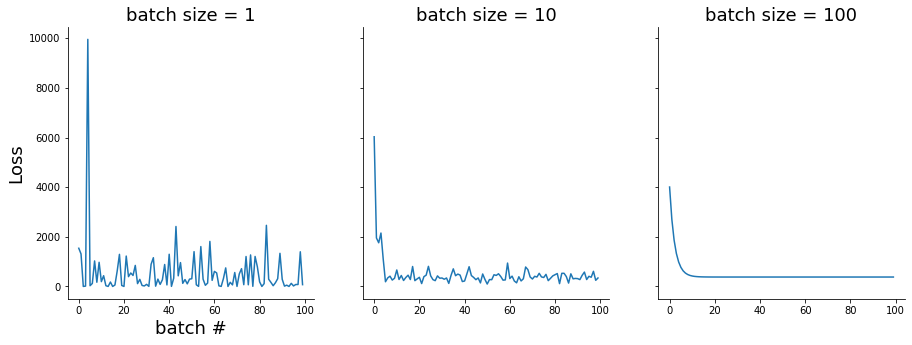

In [9]:
# create figure and axes objects
# there will be 3 subplots in one row, y-axis is shared between subplots
fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,5))

# create lists of loss values and batch sizes for further iteration in for-loop
batch_loss_list = [batch_size1_loss, batch_size10_loss, batch_size100_loss]
batch_size      = [1,10,100] 

for ax, batch_loss, size in zip(axes, batch_loss_list, batch_size):
    # plot only first 100 values
    ax.plot(np.arange(len(batch_loss[:100])), batch_loss[:100])
    # remove top and right subplot's frames 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set subplot's title
    ax.set_title("batch size = "+str(size), fontsize=18)

# set x- and y-axis labels
axes[0].set_xlabel('batch #', fontsize=18)
axes[0].set_ylabel('Loss', fontsize=18)

# display figure
plt.show()

The above figure indicates that when using SGD with a small batch size, the loss is not decreasing monotonically but somewhat randomly fluctuating around a long-term decreasing trend. This happens because the weight updates use "noisy" estimates of the gradient. The noisy estimate is calculated by an averaging process using the data points in the mini-batch. The smaller the mini-batch size, the fewer data points we use for computing the average. Thus, the gradient noise becomes stronger with smaller batch size. In order avoid the accumulation of the gradient noise while running SGD updates the learning rate needs to be gradually decreased, e.g. by using diminishing learning rate.

Below are the animations illustrating the training process with SGD where batch size is all data points (upper panel) and where batch size is 10 data points (lower panel, the current batch marked with red colour). In line with loss plots we created above, mini-batch SGD is more noisy than batch GD. Although, it seems that using plain batch GD is faster way to reach the minimum of the loss function, in practice when working with large datasets and thousands parameters (weights) in neural networks, this approach will be slower and more computationally expensive than mini-batch SGD.

**Illustration of SGD iterations for batch size = 100 (batch covers entire dataset)** 
![SegmentLocal](minibatchGD1.gif "segment")
**Illustration of SGD iterations for batch size = 10 datapoints**
![SegmentLocal](minibatchGD2.gif "segment")
During each iteration of SGD, 10 data points are randomly selected to constitute a batch. This batch is used 
to compute the gradient estimate. The data points in the batch are shown in red. Note that during 
each iteration, a different set of 10 data points is chosen for the batch. 

# Variants of Gradient-Based Optimization Algorithms

Besides plain GD or mini-batch SGD, many deep learning methods use somewhat more advanced variants of gradient-based algorithms or optimizers ([list of optimizers available in deep learning Python library Keras](https://keras.io/api/optimizers/)). Some of the most known are SGD with momentum, RMSprop and Adam. 

Much like GD and SGD, these algorithms use gradients of the loss function $f(\mathbf{w})$ to find weights $\mathbf{w}$ such that the predictor $h^{(\mathbf{w})}$ achieves (nearly) minimum loss. These variants differ in how they use (or "interpret") the gradient information to find the fastest route towards the minimum. In some cases these variants can find good weight vectors significantly faster (using fewer iterations) compared to mini-batch SGD. 

The animation below compares the "routes" taken by different optimizers to find a minimum of the [six-hump camel](https://www.sfu.ca/~ssurjano/camel6.html) function. 

![SegmentLocal](camel3D.gif "segment")

## Conclusion 

We have discussed the basic idea of using gradients of loss functions to iteratively improve the parameter values (weights) in a predictor map. Gradient based methods such as SGD and its variants turn out to be the perfect tool for training the deep neural networks in several aspects. First, somewhat surprisingly, SGD quickly finds weights for an ANN such that it performs well on new data points which are different from the training data. Moreover, mini-batch SGD requires only to have enough working memory ("RAM") to store the current batch (subset) of training data points instead of the entire dataset (which might be billions of high-resolution images). 
